In [1]:
import torch
from torch.utils.data import Dataset
import scipy.io
import os
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MatDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        """
        input_dir: 入力データのディレクトリ（例：'data/inputs'）
        target_dir: ターゲットデータのディレクトリ（例：'data/targets'）
        transform: オプションの前処理
        """
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        input_files = sorted(os.listdir(self.input_dir))
        target_files = sorted(os.listdir(self.target_dir))

        self.input_images = []   # 個々の画像（Tensor）のリスト
        self.target_images = []  # 対応するターゲット画像のリスト

        # 各グループ（＝ファイル）ごとに画像を読み込み、平坦化してリストに追加
        for input_file, target_file in zip(input_files, target_files):
            input_path = os.path.join(self.input_dir, input_file)
            target_path = os.path.join(self.target_dir, target_file)
            
            input_data = scipy.io.loadmat(input_path)['v_dopdata']    # (256, 256, 1000)
            target_data = scipy.io.loadmat(target_path)['v_thetadata']  # (256, 256, 1000)
            
            input_data = input_data.transpose(2, 0, 1)    # (1000, 256, 256)
            target_data = target_data.transpose(2, 0, 1)  # (1000, 256, 256)
            
            num_images = input_data.shape[0]
            for i in range(num_images):
                # 各画像は (256, 256) のNumPy配列 → Tensor化し、チャンネル次元を追加して (1, 256, 256) に
                img_tensor = torch.tensor(input_data[i], dtype=torch.float32).unsqueeze(0)
                tgt_tensor = torch.tensor(target_data[i], dtype=torch.float32).unsqueeze(0)
                
                if self.transform:
                    img_tensor = self.transform(img_tensor)
                    tgt_tensor = self.transform(tgt_tensor)
                
                self.input_images.append(img_tensor)
                self.target_images.append(tgt_tensor)
                
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):
        return self.input_images[idx], self.target_images[idx]

In [3]:
data_loader = DataLoader(
    MatDataset('../data/train/inputs', '../data/train/targets'), 
    batch_size=4, 
    shuffle=True
)

In [4]:
def get_global_max(data_loader):
    global_max = 0.0
    for batch in data_loader:
        inputs, targets = batch  # (batch_size, C, H, W) の形
        max_val = max(torch.abs(inputs).max().item(), torch.abs(targets).max().item())
        if max_val > global_max:
            global_max = max_val
    return global_max

In [5]:
def get_data_by_dataloader(data_loader, sample_rate=0.1):
    """ DataLoader からデータを収集し、値の分布を取得 """
    input_values = []
    target_values = []

    for i, (inputs, targets) in enumerate(data_loader):
        input_values.extend(inputs.flatten().tolist())  # 1D 配列に変換
        target_values.extend(targets.flatten().tolist())

        # 一部のデータのみ収集して計算量を抑える
        if i / len(data_loader) > sample_rate:
            break

    return input_values, target_values

In [6]:
input_values, target_values = get_data_by_dataloader(data_loader)

In [11]:
len(input_values)

59506688

In [13]:
input_values = np.array(input_values)
filtered_input_values = input_values[input_values != 0]
target_values = np.array(target_values)
filtered_target_values = target_values[target_values != 0]

In [21]:
np.max(np.abs(filtered_target_values))

np.float64(0.7881543636322021)

In [16]:
np.std(filtered_target_values)

np.float64(0.12420759747107674)

In [18]:
np.abs(filtered_target_values)

array([0.00856888, 0.01784338, 0.0221501 , ..., 0.00305111, 0.07178804,
       0.07392409], shape=(11882758,))

In [17]:
np.mean(np.abs(filtered_target_values))

np.float64(0.08152587146424149)

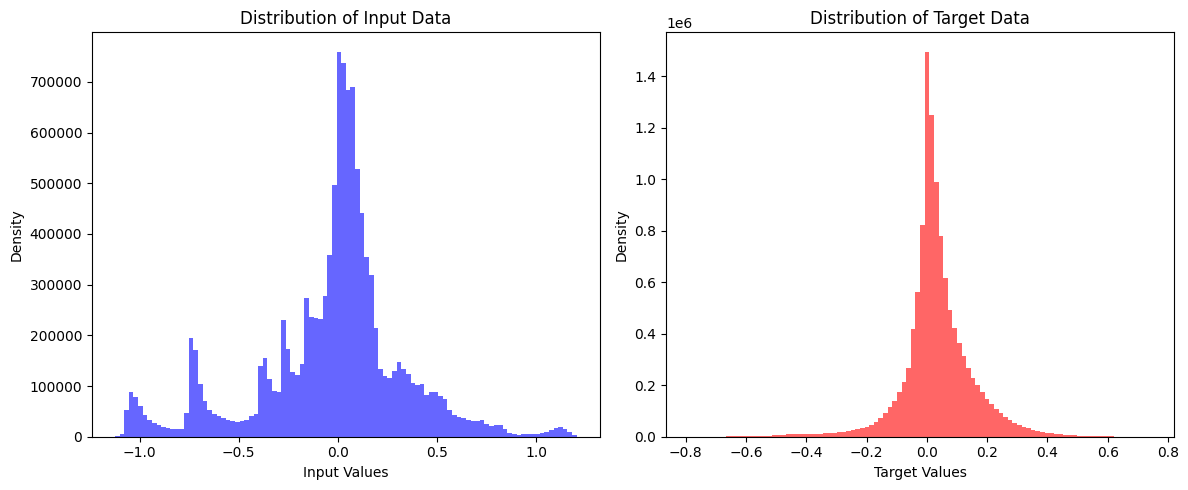

In [15]:
# ヒストグラムの描画

filtered_input_values = input_values[input_values != 0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(filtered_input_values, bins=100, density=False, alpha=0.6, color='b')
plt.xlabel("Input Values")
plt.ylabel("Density")
plt.title("Distribution of Input Data")

plt.subplot(1, 2, 2)
plt.hist(filtered_target_values, bins=100, density=False, alpha=0.6, color='r')
plt.xlabel("Target Values")
plt.ylabel("Density")
plt.title("Distribution of Target Data")

plt.tight_layout()
plt.show()

In [ ]:
# グローバル最大値を取得
global_max = get_global_max(data_loader)
print(f"Global max value: {global_max}")